<a href="https://colab.research.google.com/github/Xiongfeng-Jin/GAN-In-Action/blob/master/AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import  backend as K
from keras import objectives
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf

In [0]:
batch_size = 100
original_dim = 28 * 28
latent_dim = 2
intermediaet_dim = 256
nb_epoch = 5
epsilon_std = 1.0

In [0]:
def sampling(args):
  z_mean, z_log_var = args
  epsilon = K.random_normal(shape=(batch_size,latent_dim),mean=0.)
  return z_mean + K.exp(z_log_var / 2)*epsilon

We learn the mean $(\mu)$ and the variance $(\sigma)$. 

In [6]:
x = Input(shape=(original_dim,),name='input')
h = Dense(intermediaet_dim,activation='relu',name='encoding')(x)
z_mean = Dense(latent_dim,name='mean')(h)
z_log_var = Dense(latent_dim,name='log_variance')(h)
z = Lambda(sampling,output_shape=(latent_dim,))([z_mean,z_log_var])
encoder = Model(x,[z_mean,z_log_var,z],name='encoder')

In [0]:
input_decoder = Input(shape=(latent_dim,),name='decoder_input')
decoder_h = Dense(intermediaet_dim,activation='relu',name='decoder_h')(input_decoder)
x_decoded = Dense(original_dim,activation='sigmoid',name='flat_decoded')(decoder_h)
decoder = Model(input_decoder,x_decoded,name='decoder')

In [8]:
output_combined = decoder(encoder(x)[2])
vae = Model(x,output_combined)
vae.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 784)               0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 201988    
_________________________________________________________________
decoder (Model)              (None, 784)               202256    
Total params: 404,244
Trainable params: 404,244
Non-trainable params: 0
_________________________________________________________________


In [0]:
def vae_loss(x, x_decoded_mean,
            z_log_var=z_log_var, z_mean=z_mean,
            original_dim=original_dim):
  xent_loss = original_dim * objectives.binary_crossentropy(x, x_decoded_mean)
  kl_loss = -0.5*K.sum(1+z_log_var-K.square(z_mean) - K.exp(z_log_var),axis=1)
  return xent_loss + kl_loss

In [0]:
vae.compile(optimizer='rmsprop',loss=vae_loss)

In [0]:
(x_train,y_train), (x_test,y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train),np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test),np.prod(x_test.shape[1:])))

In [31]:
vae.fit(x_train,x_train,shuffle=True,nb_epoch=nb_epoch,batch_size=batch_size,validation_data=(x_test,x_test),verbose=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.





Train on 60000 samples, validate on 10000 samples
Epoch 1/5





60000/60000 [==============================] - 10s 161us/step - loss: 190.8876 - val_loss: 172.2520
Epoch 2/5
60000/60000 [==============================] - 9s 143us/step - loss: 170.7288 - val_loss: 168.8286
Epoch 3/5
60000/60000 [==============================] - 9s 145us/step - loss: 167.7731 - val_loss: 166.8750
Epoch 4/5
60000/60000 [==============================] - 9s 144us/step - loss: 166.0586 - val_loss: 165.0353
Epoch 5/5
60000/60000 [==============================] - 9s 145us/step - loss: 165.1116 - val_loss: 166.9629


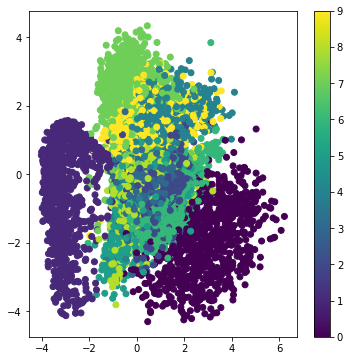

In [34]:
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)[0]
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:,0], x_test_encoded[:,1], c=y_test, cmap='viridis')
plt.colorbar()
plt.show()

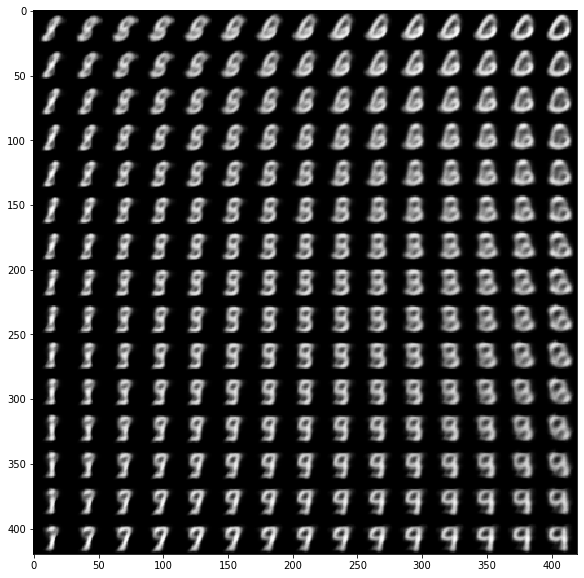

In [35]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()